In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/vydat/miniconda3/envs/ai_env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/vydat/miniconda3/envs/ai_env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
train_data_path = '/home/vydat/Code/ML_AI/BrainTumor_classifi/Training'

train_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

data = datasets.ImageFolder(
    root=train_data_path,
    transform=train_transform
)

data_size = len(data)
train_size = int(0.8*data_size)
val_size = data_size - train_size

train_data, val_data = random_split(data, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)

class_name = data.classes
num_class = len(class_name)

print(f'{num_class}')
print(f'{class_name}')
print(f'Data size: {data_size}')
print(f'Train size: {train_size}')
print(f'Val sizze: {val_size}')

4
['glioma', 'meningioma', 'notumor', 'pituitary']
Data size: 5712
Train size: 4569
Val sizze: 1143


In [70]:
#Build Neural Network
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction_ratio, kernel_size=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // reduction_ratio, in_channels, kernel_size=1, bias=False)
        )
        
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return torch.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        out = self.conv(x_cat)
        return torch.sigmoid(out)

        
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_attention = SpatialAttention(kernel_size)
        
    def forward(self, x):
        
        channel_att = self.channel_attention(x)
        x = x * channel_att

        spatial_att = self.spatial_attention(x)
        x = x * spatial_att

        return x

        
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, groups=1, stride=1):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.block(x)

        
class ResidualCBAM(nn.Module):
    def __init__(self, in_channels, out_channels, groups=1, stride=1):
        super(ResidualCBAM, self).__init__()
        self.stride = stride
        
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, groups=groups, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.dropout = nn.Dropout(0.3)
        self.cbam = CBAM(out_channels, reduction_ratio=8)

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.shortcut = nn.Identity()

        
    def forward(self, x):
        ResidualCBAM = self.shortcut(x)
        x = self.conv_block(x)
        x = self.cbam(x)
        x = self.dropout(x)
        x += ResidualCBAM
        return torch.relu(x)


class MultiScaleModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleModule, self).__init__()

        self.h_pool = nn.AdaptiveAvgPool2d((1, None))
        self.h_conv = nn.Conv2d(in_channels, out_channels//2, kernel_size=(1, 3), padding=(0, 1), bias=False)
        
        self.v_pool = nn.AdaptiveAvgPool2d((None, 1))
        self.v_conv = nn.Conv2d(in_channels, out_channels//2, kernel_size=(3, 1), padding=(1, 0), bias=False)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        h_att = self.h_conv(self.h_pool(x))
        v_att = self.v_conv(self.v_pool(x))
        
        h_att = F.interpolate(h_att, size=x.size()[2:], mode='bilinear', align_corners=False)
        v_att = F.interpolate(v_att, size=x.size()[2:], mode='bilinear', align_corners=False)
        
        attention = torch.cat([h_att, v_att], dim=1)
        attention = self.sigmoid(attention)
        
        return x * attention

class NW(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        
        # 64x64
        self.Block1 = nn.Sequential(
            ResidualCBAM(32, 32, groups=2),
            ResidualCBAM(32, 32, groups=2)
        )
        self.msm1 = MultiScaleModule(32, 32)
        self.transition1 = nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False)
        
        # 32x32
        self.Block2 = nn.Sequential(
            ResidualCBAM(64, 64, groups=4),
            ResidualCBAM(64, 64, groups=4)
        )
        self.msm2 = MultiScaleModule(64, 64)
        self.transition2 = nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False)
        
        # 16x16
        self.Block3 = nn.Sequential(
            ResidualCBAM(128, 128, groups=8),
            ResidualCBAM(128, 128, groups=8)
        )
        self.msm3 = MultiScaleModule(128, 128)
        
  
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.Block1(x)
        x = self.msm1(x)
        x = self.transition1(x)
        
        x = self.Block2(x)
        x = self.msm2(x)
        x = self.transition2(x)
       
        x = self.Block3(x)
        x = self.msm3(x)
        
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [71]:
model = NW().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
summary(model, input_size=(3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 50, 50]             864
       BatchNorm2d-2           [-1, 32, 50, 50]              64
              ReLU-3           [-1, 32, 50, 50]               0
          Identity-4           [-1, 32, 50, 50]               0
            Conv2d-5           [-1, 32, 50, 50]           1,024
       BatchNorm2d-6           [-1, 32, 50, 50]              64
              ReLU-7           [-1, 32, 50, 50]               0
            Conv2d-8           [-1, 32, 50, 50]           4,608
       BatchNorm2d-9           [-1, 32, 50, 50]              64
             ReLU-10           [-1, 32, 50, 50]               0
           Conv2d-11           [-1, 32, 50, 50]           1,024
      BatchNorm2d-12           [-1, 32, 50, 50]              64
AdaptiveAvgPool2d-13             [-1, 32, 1, 1]               0
           Conv2d-14              [-1, 

In [72]:
def train(train_loader, val_loader, model, criterion, optimizer, scheduler, device, epochs):
    train_loss, val_loss, train_acc, val_acc = [], [], [], []
    for ep in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for _, (img, label) in enumerate(train_loader):
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output, 1)
            correct += (predicted == label).sum().item()
            total += label.size(0)
            
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
            
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        for _, (img, label) in enumerate(val_loader):
            img, label = img.to(device), label.to(device)
            with torch.no_grad():
                output = model(img)
                loss = criterion(output, label)
                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                correct += (predicted == label).sum().item()
                total += label.size(0)
                
        epoch_val_loss = running_loss / len(train_loader)
        epoch_val_acc = correct / total
        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)
            
        scheduler.step(epoch_val_loss)
            
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {ep+1}/{epochs} - "
                f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} - "
                f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f} - "
                f"LR: {current_lr:.6f}")
        
        example_input = torch.randn(1, 3, 100, 100).to(device) 
        traced_model = torch.jit.trace(model, example_input)
        traced_model.save('/home/vydat/Code/ML_AI/BrainTumor_classifi/model.pt')
        
    return train_loss, val_loss, train_acc, val_acc

In [ ]:
ep = 50
train_loss, val_loss, train_acc, val_acc = train(train_loader, val_loader, model, criterion, optimizer, scheduler, device, ep)

Epoch 1/25 - Train Loss: 0.9190, Train Acc: 0.6063 - Val Loss: 0.2030, Val Acc: 0.6640 - LR: 0.001000
Epoch 2/25 - Train Loss: 0.5885, Train Acc: 0.7759 - Val Loss: 0.1438, Val Acc: 0.7953 - LR: 0.001000
Epoch 3/25 - Train Loss: 0.5110, Train Acc: 0.8137 - Val Loss: 0.1233, Val Acc: 0.7988 - LR: 0.001000
Epoch 4/25 - Train Loss: 0.4662, Train Acc: 0.8398 - Val Loss: 0.1281, Val Acc: 0.8189 - LR: 0.001000
Epoch 5/25 - Train Loss: 0.3982, Train Acc: 0.8599 - Val Loss: 0.0794, Val Acc: 0.8828 - LR: 0.001000
Epoch 6/25 - Train Loss: 0.3620, Train Acc: 0.8711 - Val Loss: 0.0981, Val Acc: 0.8731 - LR: 0.001000
Epoch 7/25 - Train Loss: 0.3109, Train Acc: 0.8917 - Val Loss: 0.0919, Val Acc: 0.8801 - LR: 0.001000
Epoch 8/25 - Train Loss: 0.2967, Train Acc: 0.8956 - Val Loss: 0.0696, Val Acc: 0.9046 - LR: 0.001000
Epoch 9/25 - Train Loss: 0.2621, Train Acc: 0.9149 - Val Loss: 0.1319, Val Acc: 0.8276 - LR: 0.001000
Epoch 10/25 - Train Loss: 0.2306, Train Acc: 0.9262 - Val Loss: 0.1069, Val Acc: 0

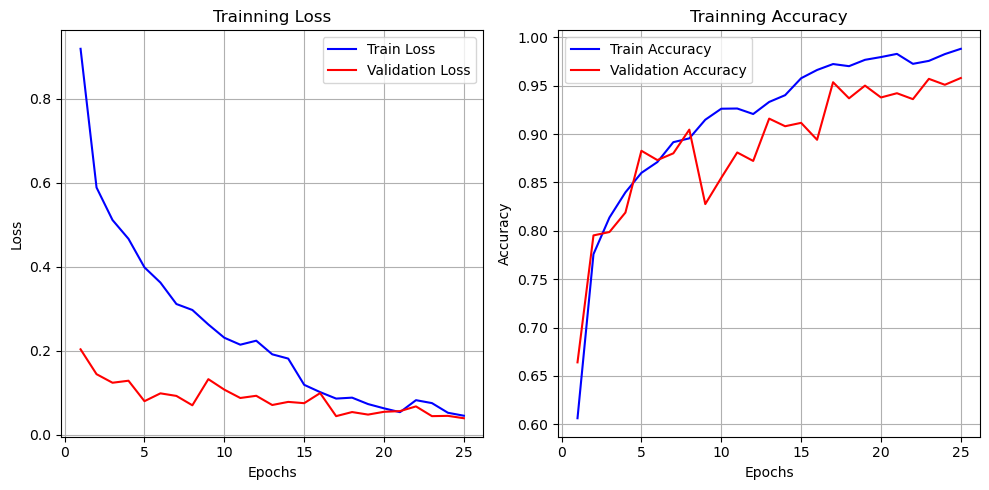

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(range(1,ep+1), train_loss, label='Train Loss', color='blue')
plt.plot(range(1, ep+1), val_loss, label='Validation Loss', color='red')
plt.title('Trainning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1,ep+1), train_acc, label='Train Accuracy', color='blue')
plt.plot(range(1, ep+1), val_acc, label='Validation Accuracy', color='red')
plt.title('Trainning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [75]:
test_path = '/home/vydat/Code/ML_AI/BrainTumor_classifi/Testing'

test_transform = transforms.Compose([
    transforms.Resize((100,100)),
    transforms.ToTensor()
])

test_data = datasets.ImageFolder(
    root=test_path,
    transform=test_transform
)
test_loader = DataLoader(test_data,batch_size=64, shuffle=False)

model = torch.load('/home/vydat/Code/ML_AI/BrainTumor_classifi/model.pt')

model.eval()
test_loss, correct, total = 0.0, 0, 0
model.eval()
wrong_images = []
wrong_preds = []
wrong_labels = []
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)

        output = model(img)
        loss = criterion(output, label)

        test_loss += loss.item() * img.size(0)
        _, predicted = torch.max(output, 1)
        correct += (predicted == label).sum().item()
        total += label.size(0)
        for i in range(len(img)):
            if predicted[i] != label[i]:
                wrong_images.append(img[i])
                wrong_preds.append(predicted[i].item())
                wrong_labels.append(label[i].item())

avg_test_loss = test_loss / total
test_acc = correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


/tmp/ipykernel_13811/1503933487.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/home/vydat/Code/ML_AI/BrainTumor_classifi/model.pt')
/home/vydat/mi

Test Loss: 0.1651
Test Accuracy: 0.9527


62


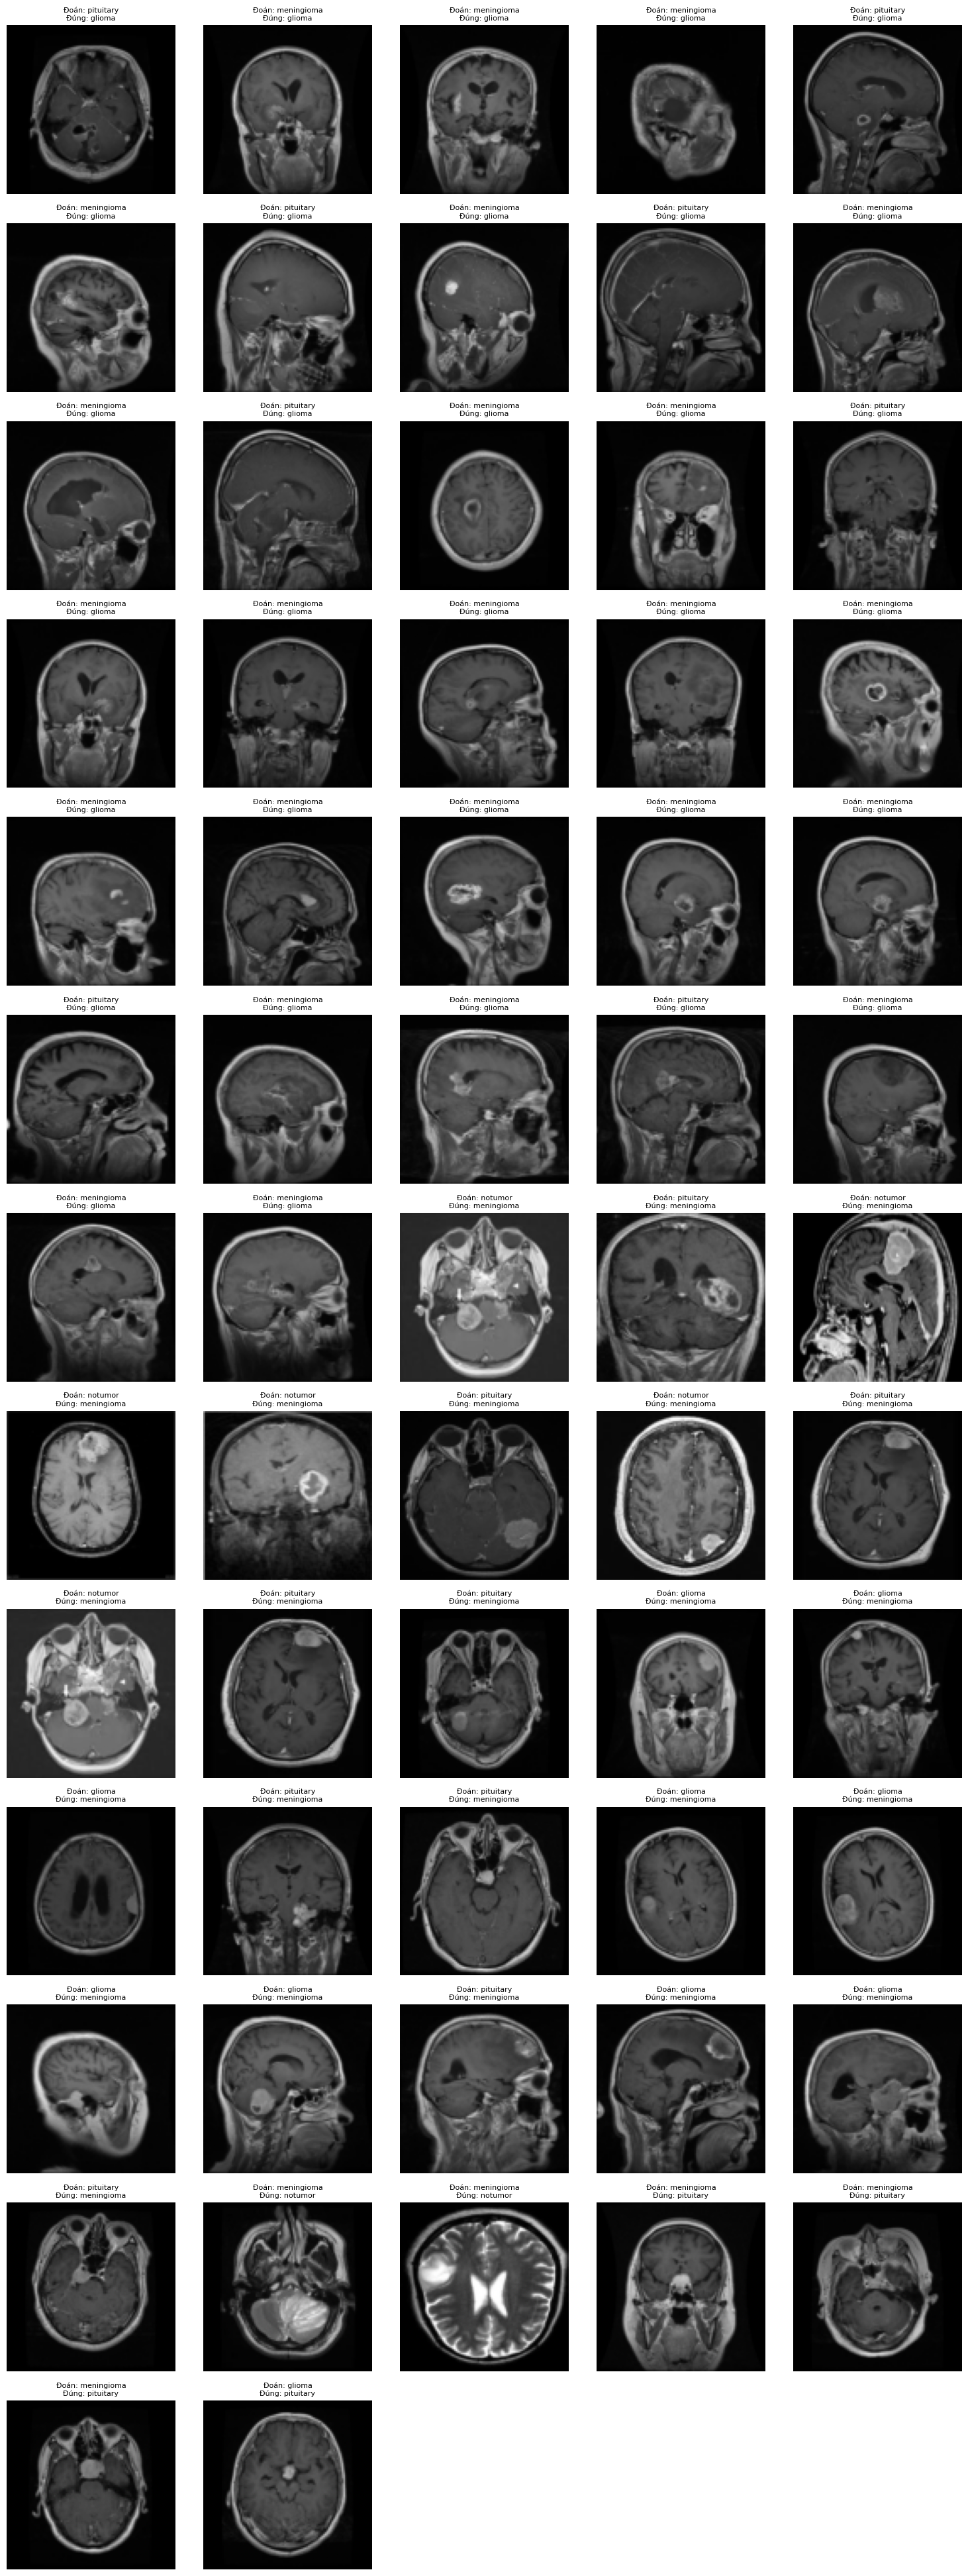

In [76]:
class_names = test_data.classes

print(len(wrong_images))
num_images = len(wrong_images)
cols = 5
rows = (num_images + cols - 1) // cols

plt.figure(figsize=(15, 3 * rows))

for i in range(num_images):
    image = wrong_images[i].cpu()
    image = image.permute(1, 2, 0)

    pred_class = class_names[wrong_preds[i]]
    true_class = class_names[wrong_labels[i]]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.title(f"Đoán: {pred_class}\nĐúng: {true_class}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()
